The goal of this notebook is to prove and visualize Jörg's theorem:

> For a specific sector, the locations of bad WX are almost always self or the nearby major airport. 
    
The corollary of this theorem is that we just need to observe the WX of the sector itself and the WX of its "reference location" to predict if a regulation is needed for this sector or not.
We do this with a step by step approach:

 - Pull allspanishairblocks.csv. Reconstruct sectors from airblock geometries.
 - GeoJSONify the coordinates and visualize the airblocks
 - Find the center of each sector
 - Pull regulations.csv. For each regulation, draw a line from the regulation.sector.center to the regulation.referenceLocation.coordinate
 
This shall prove visually that there are no two lines from a sector center to reference locations. Raw data checking in the triple store showed that this happened only once in German airspace.



## Helper functions


In [156]:
import pandas as pd
import json
import folium
from geomet import wkt
from pandas.io.json import json_normalize, read_json
from SPARQLWrapper import SPARQLWrapper, JSON, XML, RDF

#import my connection module which allows to connect to the datAcron rdf store
from datacron_connector import TripleStoreConnector
ts107 = TripleStoreConnector(0)
ts109 = TripleStoreConnector(1)


def wkt_to_geojson(dataframe, wkt_column_name, geojson_column_name):
    """
    Gets a pandas.DataFrame and converts a WKT column into a GeoJSON column.
    The GeoJSON column then contains a dict.
    
    Keyword arguments:
    dataframe -- the pandas.DataFrame which should be altered
    wkt_column_name -- the name of the column containing the well-known-text
    geojson_column_name -- how the GeoJSON column shall be named
    
    """
    if type(dataframe) != pd.core.frame.DataFrame:
        raise TypeError('The parameter dataframe must be a Pandas DataFrame.')
    if not wkt_column_name in dataframe.columns:
        raise ValueError('No column with the specified name found in the DataFrame')
    
    dataframe[geojson_column_name] = dataframe[wkt_column_name].apply(lambda x: wkt.loads(x))
    return dataframe

# to check if a polygon is convex
def zCrossProduct(a,b,c):
   return (a[0]-b[0])*(b[1]-c[1])-(a[1]-b[1])*(b[0]-c[0])

def isConvex(vertices):
    if len(vertices)<4:
        return True
    signs= [zCrossProduct(a,b,c)>0 for a,b,c in zip(vertices[2:],vertices[1:],vertices)]
    return all(signs) or not any(signs)


## Pull allspanishairblocks.csv and reconstruct sectors from airblock geometries

In [157]:
qry = """
PREFIX : <http://www.datacron-project.eu/datAcron#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX myfn: <java:datAcronTester.unipi.gr.sparql_functions.>

SELECT  ?config ?bigairspace ?airspace ?block ?start ?end ?wkt ?lowerlevel ?upperlevel
WHERE { 
   
   # get blocks:
   ?airspace dul:hasPart       ?block .
   ?block       :hasLowerLevel ?lowerlevel ;
                :hasUpperLevel ?upperlevel ;
                :hasGeometry   ?geom.
   ?geom        :hasMBR_WKT    ?wkt .
   
   # get active config times for all these blocks:
   ?bigairspace dul:hasPart ?airspace.   
   ?config      a              :FM_Configuration ;
                :hasCapacity   ?capacity ;
                :configurationOfAirspace ?bigairspace ;
             dul:hasConstituent          ?period .
   ?period      :TimeStart               ?start ;
                :TimeEnd                 ?end.
   
   
   #filter for only spanish airblocks:
   FILTER regex(str(?block), 'Airblock_LE', "i")
   
}
"""

open_airblocks = ts109.query(qry)
open_airblocks = ts109.clean(open_airblocks)
open_airblocks = open_airblocks.sort_values('block')

open_airblocks.to_csv('data/opening_times_of_airblocks_squares.csv')
print(len(open_airblocks))
open_airblocks.iloc[15:].head(5)

106741


,config,bigairspace,airspace,block,start,end,wkt,lowerlevel,upperlevel
6238,AirspaceConfiguration_LEBLTMA_5AW_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-13T20:30:00,2016-04-13T20:59:00,"POLYGON ((1.85638888888889 41.4630555555556, 1...",0.0,5943.6
6239,AirspaceConfiguration_LEBLTMA_5AW_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-15T20:30:00,2016-04-15T20:59:00,"POLYGON ((1.85638888888889 41.4630555555556, 1...",0.0,5943.6
6660,AirspaceConfiguration_LEBLTMA_5BE_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-05T20:30:00,2016-04-05T20:59:00,"POLYGON ((1.85638888888889 41.4630555555556, 1...",0.0,5943.6
6661,AirspaceConfiguration_LEBLTMA_5BE_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-08T05:00:00,2016-04-08T05:29:00,"POLYGON ((1.85638888888889 41.4630555555556, 1...",0.0,5943.6
6662,AirspaceConfiguration_LEBLTMA_5BE_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-19T20:30:00,2016-04-19T20:32:00,"POLYGON ((1.85638888888889 41.4630555555556, 1...",0.0,5943.6


In [158]:
# Einlesen der airblock - Koordinaten
airblocks = pd.read_csv('data/opening_times_of_airblocks_squares.csv')
#Konvertieren zu Sektoren und GeoJSON
sectors = airblocks[['airspace', 'block', 'wkt', 'lowerlevel', 'upperlevel']]
sectors = sectors.drop_duplicates()
sectors = wkt_to_geojson(sectors, wkt_column_name='wkt', geojson_column_name='geojson')
sectors.to_csv('data/geojsontest.csv')
print(len(sectors))
sectors.head(5)


Now we want to construct a visualization of all sectors, comprised of airblock, in spain. We start with a simple thing: just visualizing the first 100 airblocks at once, without fusioning them.

In [161]:
import folium
spainmap = folium.Map(location=[35, 5], zoom_start=3, control_scale=True, prefer_canvas=True)
#spainmap.choropleth(geo_str=str(spain))
#spainmap.save(outfile='maps/mapspain.html')
#mapspain
for index, row in sectors.head(100).iterrows():
    c = folium.GeoJson(row['geojson'], name=row['block'], overlay=True,
                       style_function = lambda feature: {'fillColor': '#ffaf00','color': 'blue', 'weight': 2.5,'dashArray': '5, 5'}, 
                       highlight_function = lambda feature: {'fillColor': '#ffaf00','color': 'green', 'weight': 5,'dashArray': '5, 5'})          
    c.add_child(folium.Popup(row['airspace'] + '\n' + row['block']))
    c.add_to(spainmap)

    
folium.LayerControl().add_to(spainmap)
spainmap.save(outfile='maps/spainmap.html')
spainmap



Hmmm it seems like there was some simplification going on in the loading of the airblock coordinates into the triple store.

According to Giorgos, I have to take care about the way of querying the data:
If you try:
PREFIX : <http://www.datacron-project.eu/datAcron#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX myfn: <java:datAcronTester.unipi.gr.sparql_functions.>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT  * WHERE {
?s :hasMBR_WKT ?mbr
} LIMIT 10

you get the MBR. If you try:

PREFIX : <http://www.datacron-project.eu/datAcron#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX myfn: <java:datAcronTester.unipi.gr.sparql_functions.>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?s (myfn:getGeom(?s) as ?actualGeom) WHERE {
?s :hasMBR_WKT ?mbr
} LIMIT 10

you get the WKT of the actual geometry :) .

Kind regards,
Giorgos


So we can construct the airblocks with a slightly different query:


In [162]:
qry = """
PREFIX : <http://www.datacron-project.eu/datAcron#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX myfn: <java:datAcronTester.unipi.gr.sparql_functions.>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT  ?config ?bigairspace ?airspace ?block ?start ?end ?geom (myfn:getGeom(?geom) as ?actualGeom) ?lowerlevel ?upperlevel
WHERE { 
   
   # get blocks:
   ?airspace dul:hasPart       ?block .
   ?block       :hasLowerLevel ?lowerlevel ;
                :hasUpperLevel ?upperlevel ;
                :hasGeometry   ?geom.
   ?geom        :hasMBR_WKT    ?wkt .
   
   # get active config times for all these blocks:
   ?bigairspace dul:hasPart ?airspace.   
   ?config      a              :FM_Configuration ;
                :hasCapacity   ?capacity ;
                :configurationOfAirspace ?bigairspace ;
             dul:hasConstituent          ?period .
   ?period      :TimeStart               ?start ;
                :TimeEnd                 ?end.
   
   
   #filter for only spanish airblocks:
   FILTER regex(str(?block), 'Airblock_LE', "i")
   
}
"""

open_airblocks = ts109.query(qry)
open_airblocks = ts109.clean(open_airblocks)
open_airblocks = open_airblocks.sort_values('block')

open_airblocks.to_csv('data/opening_times_of_airblocks_exact.csv')
print(len(open_airblocks))
open_airblocks.iloc[15:].head(5)

106741


,config,bigairspace,airspace,block,start,end,geom,actualGeom,lowerlevel,upperlevel
6238,AirspaceConfiguration_LEBLTMA_5AW_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-13T20:30:00,2016-04-13T20:59:00,http://83.212.239.107/geometries/airblocks/053LE,"POLYGON ((1.85638888888889 41.7558333333333, 2...",0.0,5943.6
6239,AirspaceConfiguration_LEBLTMA_5AW_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-15T20:30:00,2016-04-15T20:59:00,http://83.212.239.107/geometries/airblocks/053LE,"POLYGON ((1.85638888888889 41.7558333333333, 2...",0.0,5943.6
6660,AirspaceConfiguration_LEBLTMA_5BE_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-05T20:30:00,2016-04-05T20:59:00,http://83.212.239.107/geometries/airblocks/053LE,"POLYGON ((1.85638888888889 41.7558333333333, 2...",0.0,5943.6
6661,AirspaceConfiguration_LEBLTMA_5BE_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-08T05:00:00,2016-04-08T05:29:00,http://83.212.239.107/geometries/airblocks/053LE,"POLYGON ((1.85638888888889 41.7558333333333, 2...",0.0,5943.6
6662,AirspaceConfiguration_LEBLTMA_5BE_411,Airspace_LEBLTMA_411,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,2016-04-19T20:30:00,2016-04-19T20:32:00,http://83.212.239.107/geometries/airblocks/053LE,"POLYGON ((1.85638888888889 41.7558333333333, 2...",0.0,5943.6


In [164]:
# Einlesen der airblock - Koordinaten
airblocks = pd.read_csv('data/opening_times_of_airblocks_exact.csv')
#Konvertieren zu Sektoren und GeoJSON
sectorsexact = airblocks[['airspace', 'block', 'actualGeom', 'lowerlevel', 'upperlevel']]
sectorsexact = sectorsexact.drop_duplicates()
sectorsexact = wkt_to_geojson(sectorsexact, wkt_column_name='actualGeom', geojson_column_name='geojson')
sectorsexact.to_csv('data/geojsontestexact.csv')
print(len(sectorsexact))
sectorsexact.head(5)


358


,airspace,block,actualGeom,lowerlevel,upperlevel,geojson
0,Airspace_LEBLBL1_411,Airblock_LEBLBL1_053LE,"POLYGON ((1.85638888888889 41.7558333333333, 2...",0.0,5943.6,"{'type': 'Polygon', 'coordinates': [[[1.856388..."
436,Airspace_LEBLBL1_411,Airblock_LEBLBL1_054LE,"POLYGON ((2.50638888888889 41.9577777777778, 2...",2590.8,5943.6,"{'type': 'Polygon', 'coordinates': [[[2.506388..."
872,Airspace_LEBLBL1_411,Airblock_LEBLBL1_073LE,"POLYGON ((1.88277777777778 41.6066666666667, 2...",3200.4,5943.6,"{'type': 'Polygon', 'coordinates': [[[1.882777..."
1308,Airspace_LEBLBL1_411,Airblock_LEBLBL1_076LE,"POLYGON ((2.09777777777778 41.2966666666667, 2...",1981.2,5943.6,"{'type': 'Polygon', 'coordinates': [[[2.097777..."
1744,Airspace_LEBLBL2_411,Airblock_LEBLBL2_065LE,"POLYGON ((2.5675 41.4630555555556, 2.579166666...",1981.2,5943.6,"{'type': 'Polygon', 'coordinates': [[[2.5675, ..."


In [165]:
import folium
spainmap2 = folium.Map(location=[35, 5], zoom_start=3, control_scale=True, prefer_canvas=True)
#spainmap.choropleth(geo_str=str(spain))
#spainmap.save(outfile='maps/mapspain.html')
#mapspain
for index, row in sectorsexact.head(100).iterrows():
    c = folium.GeoJson(row['geojson'], name=row['block'], overlay=True,
                       style_function = lambda feature: {'fillColor': '#ffaf00','color': 'blue', 'weight': 2.5,'dashArray': '5, 5'}, 
                       highlight_function = lambda feature: {'fillColor': '#ffaf00','color': 'green', 'weight': 5,'dashArray': '5, 5'})          
    c.add_child(folium.Popup(row['airspace'] + '\n' + row['block']))
    c.add_to(spainmap2)

    
folium.LayerControl().add_to(spainmap2)
spainmap2.save(outfile='maps/spainmap2.html')
spainmap2



## Old Stuff

In [153]:
raw = 'POLYGON ((1.85638888888889 41.7558333333333, 2.52833333333333 41.8480555555556, 2.55888888888889 41.81, 2.61916666666667 41.7666666666667, 2.63972222222222 41.7572222222222, 2.84083333333333 41.6713888888889, 2.5675 41.4630555555556, 2.54277777777778 41.4955555555556, 2.52194444444444 41.5152777777778, 2.49805555555556 41.5327777777778, 2.47138888888889 41.5480555555556, 2.44222222222222 41.5605555555556, 2.41138888888889 41.5702777777778, 2.37916666666667 41.5769444444444, 2.34611111111111 41.5805555555556, 2.3125 41.5808333333333, 2.27944444444444 41.5780555555556, 2.24666666666667 41.5722222222222, 2.21555555555556 41.5636111111111, 2.16083333333333 41.5447222222222, 2.18694444444444 41.6469444444444, 1.88277777777778 41.6066666666667, 1.85638888888889 41.7558333333333))'
tripled = 'POLYGON ((1.85638888888889 41.4630555555556, 1.85638888888889 41.8480555555556, 2.84083333333333 41.8480555555556, 2.84083333333333 41.4630555555556, 1.85638888888889 41.4630555555556))'

raw_geojson = wkt.loads(raw)
tripled_geojson = wkt.loads(tripled)


exmap = folium.Map(location=[35, 5], zoom_start=3, control_scale=True, prefer_canvas=True)

d = folium.GeoJson(raw_geojson, name='raw', overlay=True)
e = folium.GeoJson(tripled_geojson, name='tripled', overlay=True)
d.add_to(exmap)
e.add_to(exmap)
    
    
folium.LayerControl().add_to(exmap)
spainmap.save(outfile='maps/exmap.html')
exmap







In [136]:
#For each sector, construct a multi-Polygon which is comprised of its sectors. Therefore:

#Construct a dict which maps one sector to the collection of all airblock coodinates.
sector = ''
sector_dict = {}

for  i in range(len(sectors)):
    sector = sectors.iloc[i]['airspace']
    coordi = sectors.iloc[i]['geojson']['coordinates'][0].copy()
    try:
        for elem in coordi:
            sector_dict[sector].append(elem)
    except KeyError:
        sector_dict[sector] = coordi

#re-geojsonify the constructed dict.
for key, value in sector_dict.items():
    sector_dict[key] = {"type": "Polygon", "coordinates": value}
    

In [150]:
spain = {'type': 'FeatureCollection', 'features':[]}

for i in range(len(sectors)):
    spain['features'].append({'type':'Feature', 'id': sectors.iloc[i]['block'],
                              'geometry': sectors.iloc[i]['geojson']['coordinates'] })

spain

{'features': [{'geometry': [[[1.85638888888889, 41.4630555555556],
     [1.85638888888889, 41.8480555555556],
     [2.84083333333333, 41.8480555555556],
     [2.84083333333333, 41.4630555555556],
     [1.85638888888889, 41.4630555555556]]],
   'id': 'Airblock_LEBLBL1_053LE',
   'type': 'Feature'},
  {'geometry': [[[2.50416666666667, 41.6713888888889],
     [2.50416666666667, 41.9577777777778],
     [3.00638888888889, 41.9577777777778],
     [3.00638888888889, 41.6713888888889],
     [2.50416666666667, 41.6713888888889]]],
   'id': 'Airblock_LEBLBL1_054LE',
   'type': 'Feature'},
  {'geometry': [[[1.88277777777778, 41.2966666666667],
     [1.88277777777778, 41.6469444444444],
     [2.18694444444444, 41.6469444444444],
     [2.18694444444444, 41.2966666666667],
     [1.88277777777778, 41.2966666666667]]],
   'id': 'Airblock_LEBLBL1_073LE',
   'type': 'Feature'},
  {'geometry': [[[2.09777777777778, 41.2966666666667],
     [2.09777777777778, 41.5808333333333],
     [2.5675, 41.580833333333

In [148]:
import folium
spainmap = folium.Map(location=[35, 5], zoom_start=3, control_scale=True, prefer_canvas=True)
#spainmap.choropleth(geo_str=str(spain))
#spainmap.save(outfile='maps/mapspain.html')
#mapspain



One comment on this construction. We are loosing altitude info here. I would need to construct the Polygon-Collection with a different method to preserve altitude information.

In [137]:

print(sector_dict['Airspace_LEBLBL1_411'])

{'type': 'Polygon', 'coordinates': [[1.85638888888889, 41.4630555555556], [1.85638888888889, 41.8480555555556], [2.84083333333333, 41.8480555555556], [2.84083333333333, 41.4630555555556], [1.85638888888889, 41.4630555555556], [2.50416666666667, 41.6713888888889], [2.50416666666667, 41.9577777777778], [3.00638888888889, 41.9577777777778], [3.00638888888889, 41.6713888888889], [2.50416666666667, 41.6713888888889], [1.88277777777778, 41.2966666666667], [1.88277777777778, 41.6469444444444], [2.18694444444444, 41.6469444444444], [2.18694444444444, 41.2966666666667], [1.88277777777778, 41.2966666666667], [2.09777777777778, 41.2966666666667], [2.09777777777778, 41.5808333333333], [2.5675, 41.5808333333333], [2.5675, 41.2966666666667], [2.09777777777778, 41.2966666666667]]}


In [108]:
#write the dict back into a DataFrame




358


0        Airspace_LEBLBL1_411
436      Airspace_LEBLBL1_411
872      Airspace_LEBLBL1_411
1308     Airspace_LEBLBL1_411
1744     Airspace_LEBLBL2_411
2180     Airspace_LEBLDDN_411
2616     Airspace_LEBLDDN_411
3052     Airspace_LEBLDDS_411
3488     Airspace_LEBLDDS_411
3924     Airspace_LEBLDDS_411
4360     Airspace_LEBLDDS_411
4796    Airspace_LEBLGARI_411
5232    Airspace_LEBLGONA_411
5668    Airspace_LEBLGONA_411
6104    Airspace_LEBLGONA_411
6540     Airspace_LEBLGR1_411
6976     Airspace_LEBLGR1_411
7412     Airspace_LEBLGR1_411
7848     Airspace_LEBLGR1_411
8284     Airspace_LEBLGR2_411
Name: airspace, dtype: object

# Old stuff

In [ ]:
import pandas as pd

In [2]:
import pandas as pd
regs = pd.read_csv('data/CRIDA-Regulations-20160401-20160430.csv',';')
regs = regs.set_index('RegulationId')
regs = regs.sort_index()
regs.head(20)

,dateReference,RegulationStart,TrafficVolumeSet,ReferenceLocation,ReferenceLocationType,TrafficVolume,RegulationEnd,RegulationActivity,RegulationCancelTime,RegulationDuration,AiracCycle,RegulationCategory,RegulationReasonCode,RegulationDescription
RegulationId,,,,,,,,,,,,,,
AR1ORT01,20160401,20160401 00:00:00,SCENAR,ORTIS,SP,AR1ORT,20160401 04:00:00,T,NaN,240,411,T,R,NaN
AR1ORT27,20160427,20160427 17:00:00,SCENAR,ORTIS,SP,AR1ORT,20160428 00:00:00,T,NaN,420,411,T,R,NaN
AR1ORT28,20160428,20160428 00:00:00,SCENAR,ORTIS,SP,AR1ORT,20160429 00:00:00,T,NaN,1440,412,T,R,NaN
AR1ORT29,20160429,20160429 00:00:00,SCENAR,ORTIS,SP,AR1ORT,20160429 04:00:00,T,NaN,240,412,T,R,NaN
AR2RV01,20160401,20160401 00:00:00,SCENAR,SARAY,SP,AR2RV,20160401 04:00:00,T,NaN,240,411,T,R,NaN
AR2RV27,20160427,20160427 17:00:00,SCENAR,SARAY,SP,AR2RV,20160428 00:00:00,T,NaN,420,411,T,R,NaN
AR2RV28,20160428,20160428 00:00:00,SCENAR,SARAY,SP,AR2RV,20160429 00:00:00,T,NaN,1440,412,T,R,NaN
AR2RV29,20160429,20160429 00:00:00,SCENAR,SARAY,SP,AR2RV,20160429 04:00:00,T,NaN,240,412,T,R,NaN
ASU17M,20160417,20160417 05:50:00,LECMFMP,LECMASU,AS,LECMASU,20160417 07:40:00,C,20160417 06:19:27,29,411,T,C,NaN


In [10]:
filtered = regs[['TrafficVolume', 'ReferenceLocation']]

filtered = filtered.drop_duplicates()

print(len(filtered))
filtered.head(20)

581


,TrafficVolume,ReferenceLocation
RegulationId,,
AR1ORT01,AR1ORT,ORTIS
AR2RV01,AR2RV,SARAY
ASU17M,LECMASU,LECMASU
BBAS28,LECBBAS1,LECBBAS
BBDX01N,LFBBDX,LFBBBDX
BFBDX01,LFBFBDX,LFBBFBDX
BL12N24,BL12N,LEBLCORE
BL402,LFBL4,LFBBL4
BLI10,LECMBLI,LECMBLI


In [15]:
vc = filtered.TrafficVolume.value_counts()
vc

FL10NTM     2
FL11NTM     2
RR1RNE      1
FL2L1K      1
LFRVKW      1
EDUSAL1A    1
LFSBBM      1
LFPO        1
LSTSAW      1
LIMF        1
EDWFLG      1
MASH5WH     1
LECBLVU1    1
LFEUN4      1
FL1BR4      1
EGTTRED     1
MASBOLN     1
FL3BEH      1
GCXOARR     1
EDUDI2C     1
EDG1LA05    1
LFPN        1
FL1TLU      1
LFMWW       1
LFEURMN4    1
LIRN        1
FL5LVU      1
LFMD        1
EDG6PAD     1
LQ3LU       1
           ..
GCLPDEP     1
EGPDCS      1
LCS12WX     1
MASD5JH     1
LFBDSIV     1
RR1MAR      1
LFRGA       1
EDDSARR     1
LEBLARR     1
LIMC        1
LFSBARR     1
LGSTRDE8    1
LSZBAORX    1
LEMGARR1    1
LIRADST     1
EPWR        1
LCS2        1
LFFLMHJ1    1
LFFAOMLM    1
LFLBARR     1
LFRQXU      1
LGSTRAR4    1
LEBLT1E1    1
LIPE        1
GCCCIGC     1
FL7DGU      1
EDGG7       1
RR5EDG4     1
LGAVDEP     1
LFTZ        1
Name: TrafficVolume, dtype: int64

In [16]:
mask = filtered[ filtered['TrafficVolume']== 'FL10NTM']

mask

,TrafficVolume,ReferenceLocation
RegulationId,,
FL10NM02,FL10NTM,EDUUNTM33
FL10NT30,FL10NTM,EDUUNTM3C


In [17]:
len(vc)

579

In [2]:
#Compare number of WX based and non WX based regulations
regswx = regs.ix[ (regs['RegulationReasonCode']== 'W') ]
regsnonwx = regs.ix[ (regs['RegulationReasonCode']!= 'W') ]
a = regswx['TrafficVolumeSet'].count()
b = regsnonwx['TrafficVolumeSet'].count()
print(a)
print(b)

173
2476


<IPython.core.display.Javascript object>


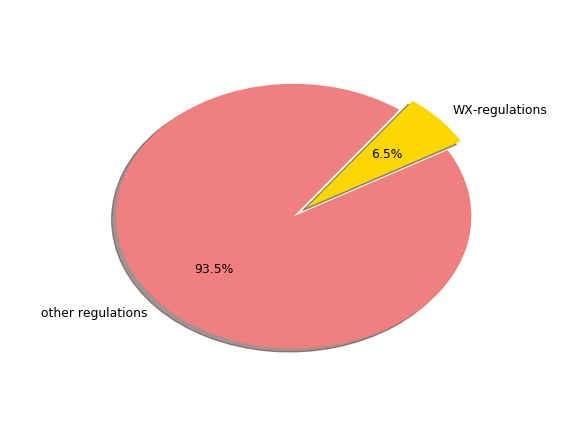

([<matplotlib.patches.Wedge at 0x7f72f4b75c50>,
  <matplotlib.text.Text at 0x7f72f4b168d0>])

In [3]:
#%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt

#Daten setzen
labels = 'WX-regulations' , 'other regulations'
sizes = [a,b]
colors = ['gold','lightcoral']
explode= (0.1,0)

#plotten
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=30)

In [4]:
start = regswx['RegulationStart'].min()
start

'20160401 04:40:00'

In [5]:
end = regswx['RegulationStart'].max()
end

'20160430 05:00:00'

In [6]:
#Part of WX -regulations where sector with bad WX is the same as regulated sector

regssame = regswx.ix[ (regswx['TrafficVolume']== regswx['ReferenceLocation'] ) ]

c = regssame['TrafficVolume'].count()



<IPython.core.display.Javascript object>


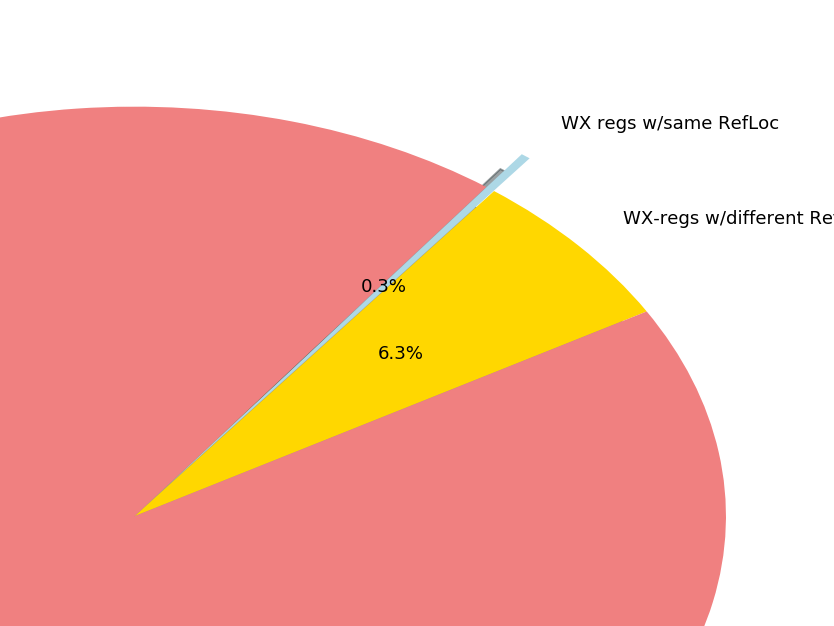

([<matplotlib.patches.Wedge at 0x7f0e8745a160>,
  <matplotlib.text.Text at 0x7f0e874786a0>])

In [9]:
#Insert this number into pie chart above
import matplotlib.pyplot as plt
%matplotlib notebook

#Daten setzen
labels = ('WX-regs w/different RefLoc' ,'WX regs w/same RefLoc', 'other regs')
sizes = [a-c, c, b]
colors = ['gold', 'lightblue', 'lightcoral']
explode= (0,0.1,0)

#plotten
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=30)

<IPython.core.display.Javascript object>


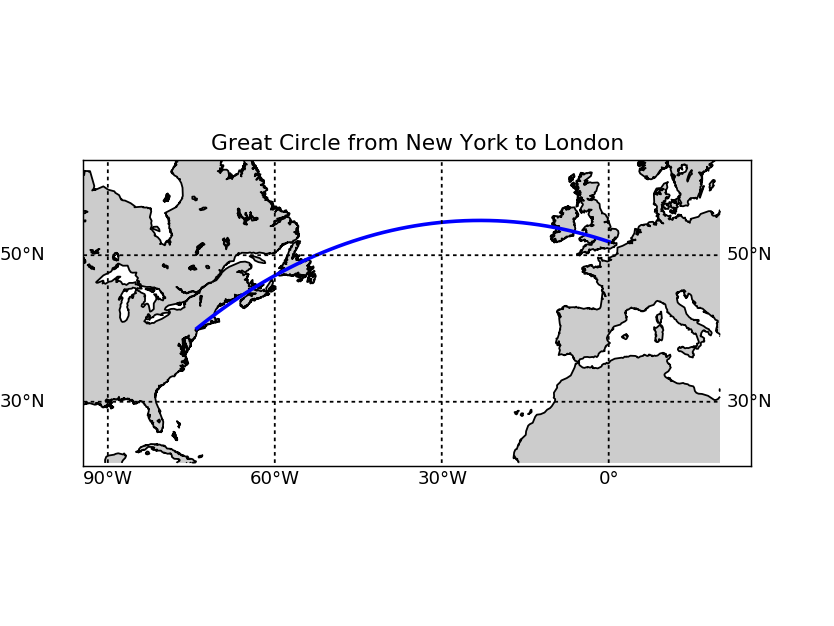

/home/joerg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/joerg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/joerg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


In [10]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title('Great Circle from New York to London')
plt.show()


In [12]:
av = regswx['RegulationDuration'].mean()
av

121.84393063583815